<a href="https://colab.research.google.com/github/chunyuan0221/3rd-ML100days/blob/master/Day_081_regularizer_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

#### Regular_ratio & Regular_mode
***
- 加入regularizer(正規化)，來避免結果overfitting。
- 在建立model函式中加入:
    1. regular_ratio:正規化數值
    2. regular_mode:正規化模式(L1 or L2 or L1_L2)


In [0]:
from keras.regularizers import l1, l2, l1_l2
def build_mlp(input_shape, output_neuron=10, layer_neuron=[512, 256, 128], regular_ratio=1e-4, regular_mode=0):
    """Code Here
    建立你的神經網路
    """
    regular = [l1, l2,l1_l2]
    input_layer = keras.layers.Input(shape=input_shape)
    for i, neuron in enumerate(layer_neuron):
        if i == 0:
            x = keras.layers.Dense(units=neuron, 
                                   activation='relu',
                                   name='hidden_layer_%s' %str(i+1),       # 字串內不能留白
                                   kernel_regularizer=regular[regular_mode](regular_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=neuron, 
                                   activation='relu',
                                   name='hidden_layer_%s' %str(i+1),
                                   kernel_regularizer=regular[regular_mode](regular_ratio))(x)
        
    output_layer = keras.layers.Dense(units=output_neuron, activation='softmax', name='output_layer')(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    return model

In [0]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.9
REG_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results_l1 = {}
results_l2 = {}
results_l1_l2 = {}
result = [results_l1, results_l2, results_l1_l2]
result_name = ['results_l1', 'results_l2', 'results_l1_l2']

"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i in range(len(result)):
    for ratio in REG_EXP:
        keras.backend.clear_session()
        print('Experiment with %s=%s' %(result_name[i], ratio))
        model = build_mlp(input_shape=x_train.shape[1:], regular_ratio=ratio, regular_mode=i)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test))

        result[i]['%s=%s' %(result_name[i], ratio)] = dict(train_acc=model.history.history['acc'],
                                                               valid_acc=model.history.history['val_acc'],
                                                               train_loss=model.history.history['loss'],
                                                               valid_loss=model.history.history['val_loss'])
    

Experiment with results_l1=0.01
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               131328    
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 128)               32896     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=========

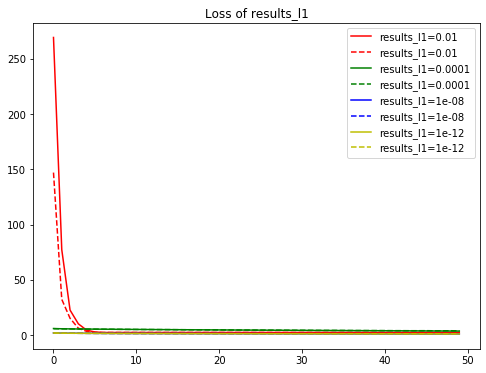

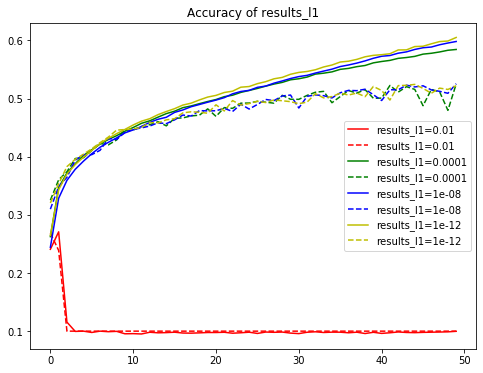

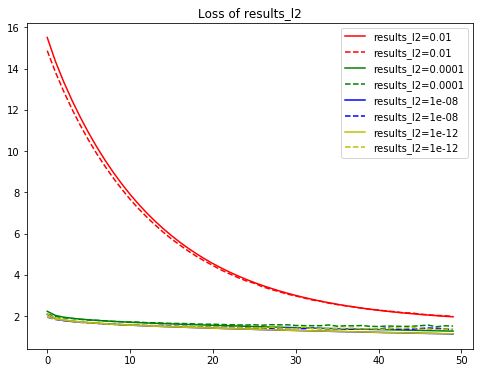

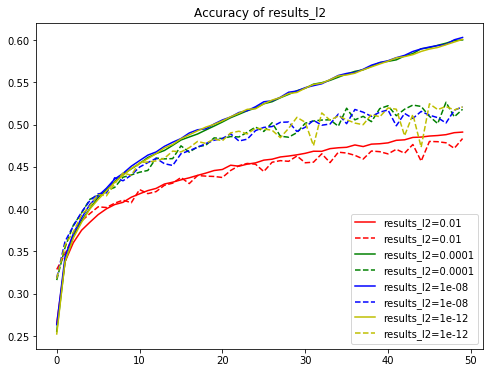

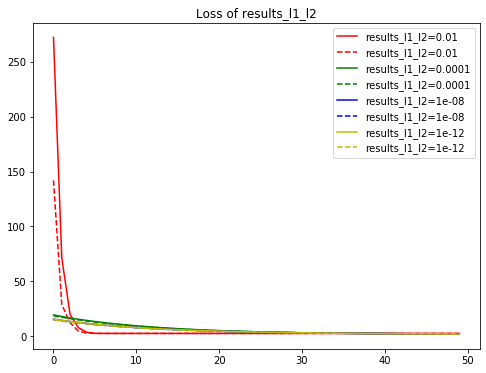

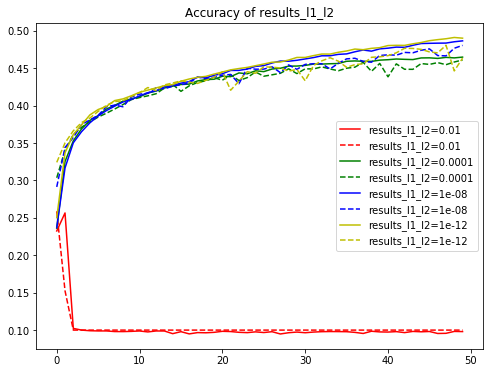

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
for i in range(len(result_name)):
    colorbar= ['r', 'g', 'b', 'y', 'm']
    plt.figure(figsize=(8, 6))
    for j, key in enumerate(result[i].keys()):
        plt.plot(result[i][key]['train_loss'], '-', color=colorbar[j], label=key)
        plt.plot(result[i][key]['valid_loss'], '--', color=colorbar[j], label=key)
    plt.title('Loss of %s' %result_name[i])
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    for j, key in enumerate(result[i].keys()):
        plt.plot(result[i][key]['train_acc'], '-', color=colorbar[j], label=key)
        plt.plot(result[i][key]['valid_acc'], '--', color=colorbar[j], label=key)
    plt.title('Accuracy of %s' %result_name[i])
    plt.legend()
    plt.show()

### Result
***
- 由結果所示，我們可以看到L1 regularizer和L1_L2 regularizer在Learning rate較大時，容易underfitting(訓練結果與驗證結果都無法有好的結果)。
- 但在L2 regularizer我們可以看到在不同Learning rate上皆能有較好的訓練結果。